
## Dataset & Libraries
I got the dataset from [Kaggle](https://www.kaggle.com/datasets/tunguz/bigmac-index). 


In [117]:
#importing all libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn import metrics
import kagglehub

In [118]:
# Loading the dataset
df = pd.read_csv('Advertising.csv')

In [119]:
# Displaying the first few rows
print("Dataset Head:")
print(df.head())

Dataset Head:
   Unnamed: 0     TV  radio  newspaper  sales
0           1  230.1   37.8       69.2   22.1
1           2   44.5   39.3       45.1   10.4
2           3   17.2   45.9       69.3    9.3
3           4  151.5   41.3       58.5   18.5
4           5  180.8   10.8       58.4   12.9


In [120]:
# Checking the shape of the dataset
print("\nDataset Shape:", df.shape)


Dataset Shape: (200, 5)


In [121]:
# Checking for null values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Unnamed: 0    0
TV            0
radio         0
newspaper     0
sales         0
dtype: int64


In [122]:
# Checking data types
print("\nData Types:")
print(df.info())


Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   radio       200 non-null    float64
 3   newspaper   200 non-null    float64
 4   sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB
None


In [123]:
# The first column ‘Unnamed’ has information about the column number which is of no use to us. 
# Let’s drop the column as we proceed further.

# Drop the first column
df.drop(df.columns[0], axis=1, inplace=True)

# Verify the column is dropped
print("\nDataset Head after dropping 'Unnamed' column:")
print(df.head())


Dataset Head after dropping 'Unnamed' column:
      TV  radio  newspaper  sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9


## Exploratory Data Analysis

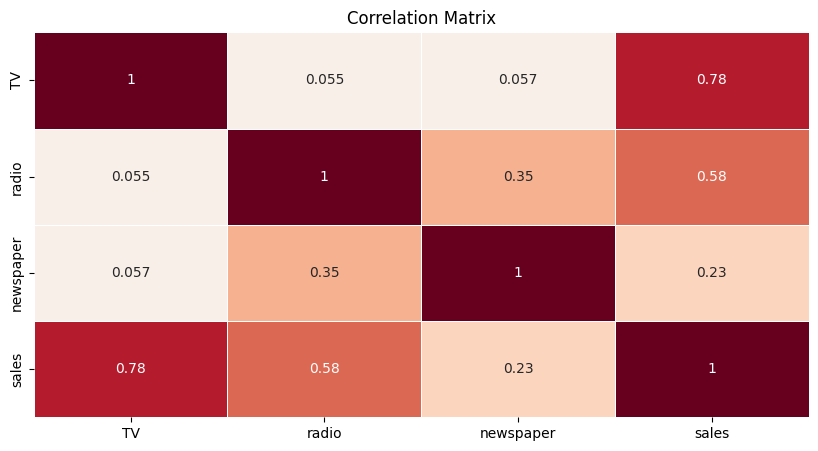

In [124]:
# Correlation Matrix: Table that shows the correlation values for each pair-relationship

plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap='RdBu_r')
plt.title('Correlation Matrix')
plt.show()

From the above correlation matrix, we can state that Sales and TV have a strong correlation(0.78), with Sales and Radio showing a medium correlation(0.58) whereas Sales and Newspapers are highly uncorrelated(0.23).

### 2. Feature Importance:

In [125]:
# Feature importance enables the assessment of the significance of each input variable in predicting the output variable. A feature is deemed important when shuffling its values increases model error, indicating that the model heavily relied on the feature for making predictions.

X = df.loc[:, df.columns != 'sales']
y = df['sales']

In [126]:
# Building Random Forest model
# Using a small portion for splitting to demonstrate feature importance quickly
X_train_fi, X_test_fi, y_train_fi, y_test_fi = train_test_split(X, y, test_size=.25, random_state=0)

model_fi = RandomForestRegressor(random_state=1)
model_fi.fit(X_train_fi, y_train_fi)

RandomForestRegressor(random_state=1)

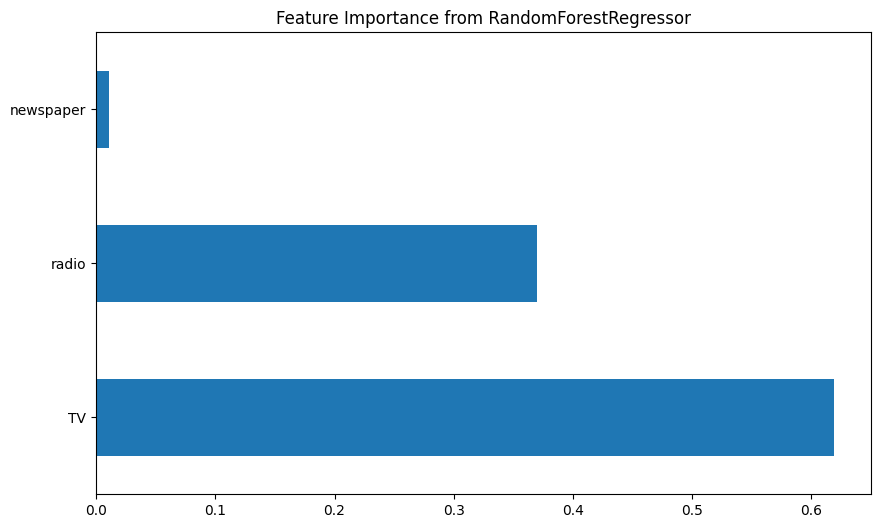

In [127]:

feat_importances = pd.Series(model_fi.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,6)) 
plt.title('Feature Importance from RandomForestRegressor')
plt.show()

TV >>> Radio >>> Newspaper

### 3. Pair Plots:

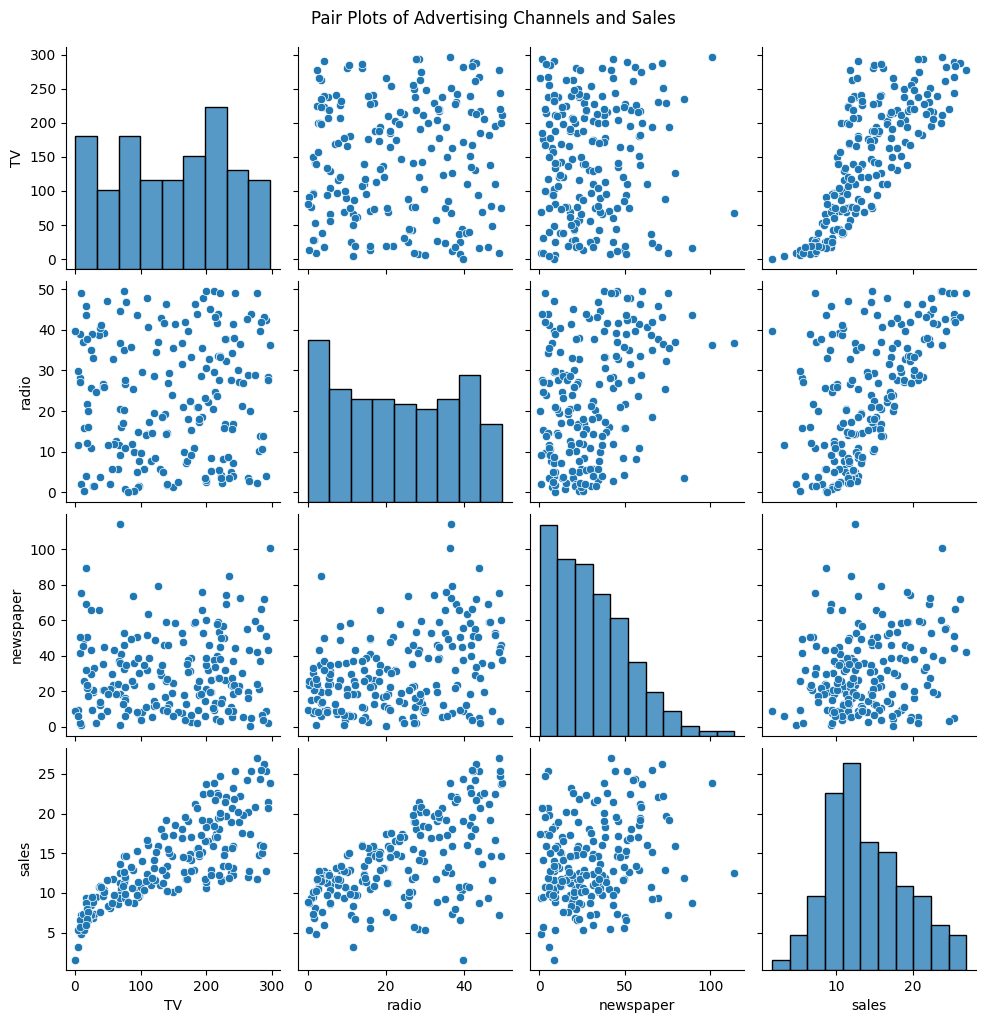

In [128]:
sns.pairplot(df)
plt.suptitle('Pair Plots of Advertising Channels and Sales', y=1.02) 
plt.show()

From this plot, we can state that there is observable coherence between our pair plot and the initial correlation matrix. It indicates a robust positive correlation between TV and sales, a comparatively weaker correlation for radio, and an even lesser correlation for newspapers.

We can also see that the newspaper distribution looks right-skewed. Let’s try and un-skew it using Box-Cox transformation.


### Box-Cox Transformation

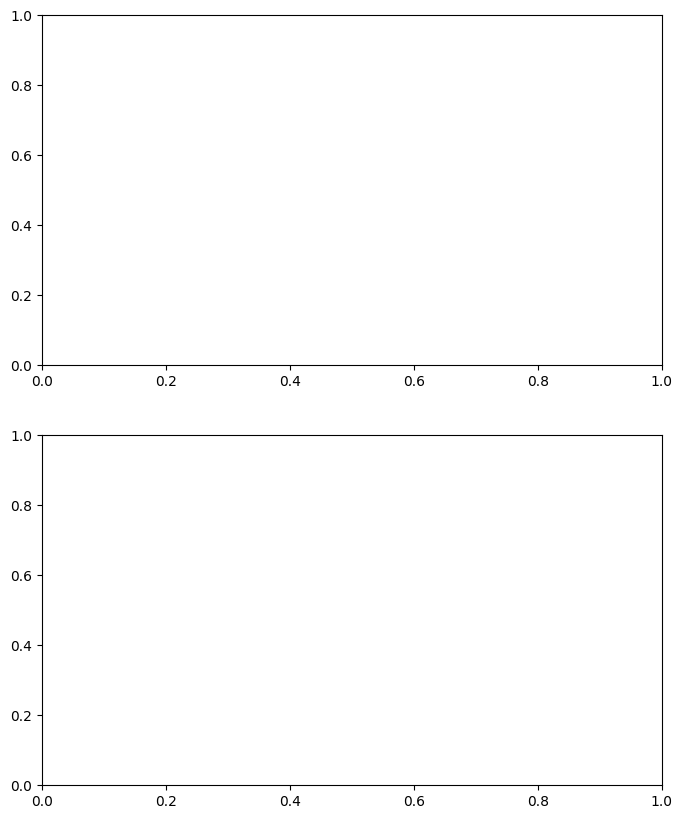

In [129]:
# Store original 'newspaper' column before transformation for comparison plot
newspaper_original = df['newspaper']

fig, axes = plt.subplots(2, 1, figsize=(8, 10))

In [130]:
# Original data probplot
stats.probplot(newspaper_original, dist=stats.norm, plot=axes[0])
axes[0].set_title('Probplot against normal distribution (Original Newspaper)')
axes[0].set_xlabel('') 

Text(0.5, 424.44444444444446, '')

In [131]:
# Apply Box-Cox transformation
# The stats.boxcox function returns the transformed data and the lambda value
df['newspaper'], lambda_value = stats.boxcox(newspaper_original + 1) # Added +1 to handle potential zeros if they existed, common practice.

In [132]:
# Transformed data probplot
stats.probplot(df['newspaper'], dist=stats.norm, plot=axes[1])
axes[1].set_title('Probplot after Box-Cox transformation (Newspaper)')
axes[1].set_xlabel('Theoretical Quantiles') # Standard probplot xlabel
axes[1].set_ylabel('Ordered Values') # Standard probplot ylabel

Text(4.444444444444452, 0.5, 'Ordered Values')

In [133]:
print(f"Lambda value for Box-Cox transformation: {lambda_value}")
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

Lambda value for Box-Cox transformation: 0.38009828248540967


<Figure size 640x480 with 0 Axes>

After the Box-cox transformation, we can see that the ‘Newspaper’ column data is no more skewed and is closer to a normal distribution.

Now that we have finished transforming data and performed exploratory analysis, it is time to build the model.

## Linear Regression

In [134]:
# Prepare data for Linear Regression
X = df[["TV","radio",'newspaper']] # Use the transformed 'newspaper'
y = df.sales

# Split data into training and testing sets
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3, random_state=42) # Added random_state for reproducibility

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(xtrain,ytrain)

# Make predictions on the test set
yPred = model.predict(xtest)


# Store results for comparison (Optional, as shown in article)
result = pd.DataFrame()
result['xtest - tv'] = xtest['TV'].copy()
result['xtest - radio'] = xtest['radio'].copy()
result['xtest - newspaper'] = xtest['newspaper'].copy() # Include transformed newspaper
result['ytest'] = ytest.copy()
result['ypred'] = yPred.copy()

print("\nActual vs Predicted Sales Sample:")
print(result.head())


Actual vs Predicted Sales Sample:
     xtest - tv  xtest - radio  xtest - newspaper  ytest      ypred
95        163.3           31.6           9.344170   16.9  16.561974
15        195.4           47.7           9.344170   22.4  21.194654
30        292.9           28.3           8.474299   21.4  21.572798
158        11.7           36.9           8.662682    7.3  10.899197
128       220.3           49.0           1.908518   24.7  22.162891


## Model Evaluation

In [135]:
# After running the model, we received the following metrics:

print('\n--- Model Evaluation Metrics ---')
print('MAE : ', metrics.mean_absolute_error(ytest,yPred))
print('MSE : ', metrics.mean_squared_error(ytest,yPred))
print('RMSE : ', np.sqrt(metrics.mean_squared_error(ytest,yPred)))
print('R-Squared : ', (metrics.r2_score(ytest,yPred))*100)
print('---------------------------------')


--- Model Evaluation Metrics ---
MAE :  1.5029632987521153
MSE :  3.7494813164127487
RMSE :  1.9363577449461007
R-Squared :  86.26795421989115
---------------------------------


An R² value of 86.27% indicates that the model provides a very high level of explanatory power, suggesting that the chosen independent variable(s)(in this case, T.V., radio and newspaper) are effective in predicting the variation observed in the dependent variable (sales of the product). 

This is a strong indication that the model is a good fit for the data, and the explained variability is significantly high.


## Coefficients

In [136]:
cdf = pd.DataFrame(model.coef_, X.columns, columns=['Coefficients'])
print("\nModel Coefficients:")
print(cdf)


Model Coefficients:
           Coefficients
TV             0.044103
radio          0.199811
newspaper      0.052408


From above, we can build the equation —

$$ Sales = 0.044 \times T.V. + 0.199 \times radio + 0.052 \times newspaper_{transformed} $$

The lower coefficient of T.V. might raise questions and it’s possible for a variable with a high correlation to have a lower coefficient in a linear regression equation, and this scenario can occur due to multicollinearity.
